#### Import libraries

In [1]:
#local libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#spark

import databricks.koalas as ks
from pyspark import SparkConf
from pyspark.sql import SparkSession

#### Create SparkSession

In [2]:
conf = SparkConf().setAll([("spark.master", "local"), ("spark.driver.memory", "2g")])

spark = SparkSession.builder.config(conf = conf).getOrCreate()


#### Import data

In [3]:
df = ks.read_csv("/Users/ramonsotogarcia/Desktop/Data/pokemon.csv", header = 0)

df.spark.cache()

df.count()

abilities            801
against_bug          801
against_dark         801
against_dragon       801
against_electric     801
against_fairy        801
against_fight        801
against_fire         801
against_flying       801
against_ghost        801
against_grass        801
against_ground       801
against_ice          801
against_normal       801
against_poison       801
against_psychic      801
against_rock         801
against_steel        801
against_water        801
attack               801
base_egg_steps       801
base_happiness       801
base_total           801
capture_rate         801
classfication        801
defense              801
experience_growth    801
height_m             781
hp                   801
japanese_name        801
name                 801
percentage_male      703
pokedex_number       801
sp_attack            801
sp_defense           801
speed                801
type1                801
type2                417
weight_kg            781
generation           801


In [4]:
df.columns


Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

### Feature engineering

In [5]:
#select columns of interest

features = ["attack", "defense", "name", "type1", "hp", "weight_kg", "is_legendary", "speed"]

df = df.loc[:, features]


#set feature names to spanish

df.rename(columns = {"attack": "ataque", "defense": "defensa", "name": "pokemon", "type1": "clase", "weight_kg": "peso(kg)", "is_legendary": "legendario", "speed": "velocidad"}, inplace = True)




#### Missing values

In [6]:
df.isna().sum(axis = 0) / df.shape[0]

ataque        0.000000
defensa       0.000000
pokemon       0.000000
clase         0.000000
hp            0.000000
peso(kg)      0.024969
legendario    0.000000
velocidad     0.000000
dtype: float64

#### Impute missing values

In [7]:
df["peso(kg)"].fillna(value = df["peso(kg)"].mean(), inplace = True)  #usamos el promedio del peso para reemplazar los missings

In [8]:
df.isna().sum(axis = 0) / df.shape[0]  #comprobamos que no tenemos missing values

ataque        0.0
defensa       0.0
pokemon       0.0
clase         0.0
hp            0.0
peso(kg)      0.0
legendario    0.0
velocidad     0.0
dtype: float64

### Exploratory data analysis

In [9]:
df.groupby("legendario").mean().sort_values(by = "ataque", ascending = False)[["ataque", "defensa", "velocidad"]]

,ataque,defensa,velocidad
legendario,,,
1,109.357143,99.400000,95.428571
0,74.841313,70.481532,63.548564


Vemos que los pokemon legendarios tienen un promedio de ataque, defensa y velocidad mucho mayor que los no legendarios

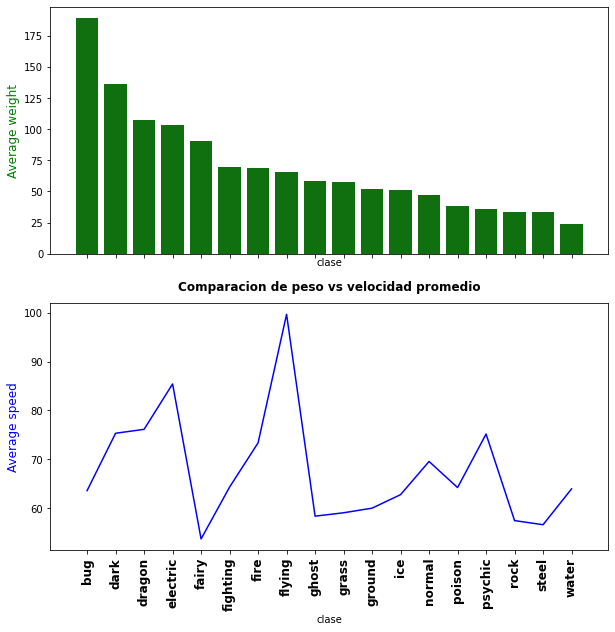

In [10]:
new = df.groupby("clase").mean().sort_values(by = "peso(kg)", ascending = False)

clase = new.index.to_numpy()
peso_medio = df.groupby("clase").mean().sort_values(by = "peso(kg)", ascending = False)["peso(kg)"].to_numpy()
v_media = df.groupby("clase").mean().sort_values(by = "peso(kg)", ascending = False)["velocidad"].to_numpy()

pdf = pd.DataFrame(data = dict(clase = clase, avg_speed = v_media, peso_avg = peso_medio))

f, (ax1, ax2) = plt.subplots(sharex = True, nrows = 2, figsize = (10,10))

plt.title("Comparacion de peso vs velocidad promedio", fontsize = 12, fontweight = "bold", pad = 13)


sns.barplot(data = pdf, x = "clase", y = "peso_avg", color = "green", ax = ax1)
ax1.set_ylabel("Average weight", color = "green", fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12, fontweight = "bold")
plt.xlabel("")

sns.lineplot(data = pdf, x = "clase", y = "avg_speed", color = "blue", ax = ax2)
ax2.set_ylabel("Average speed", color = "blue", fontsize = 12)
plt.show()


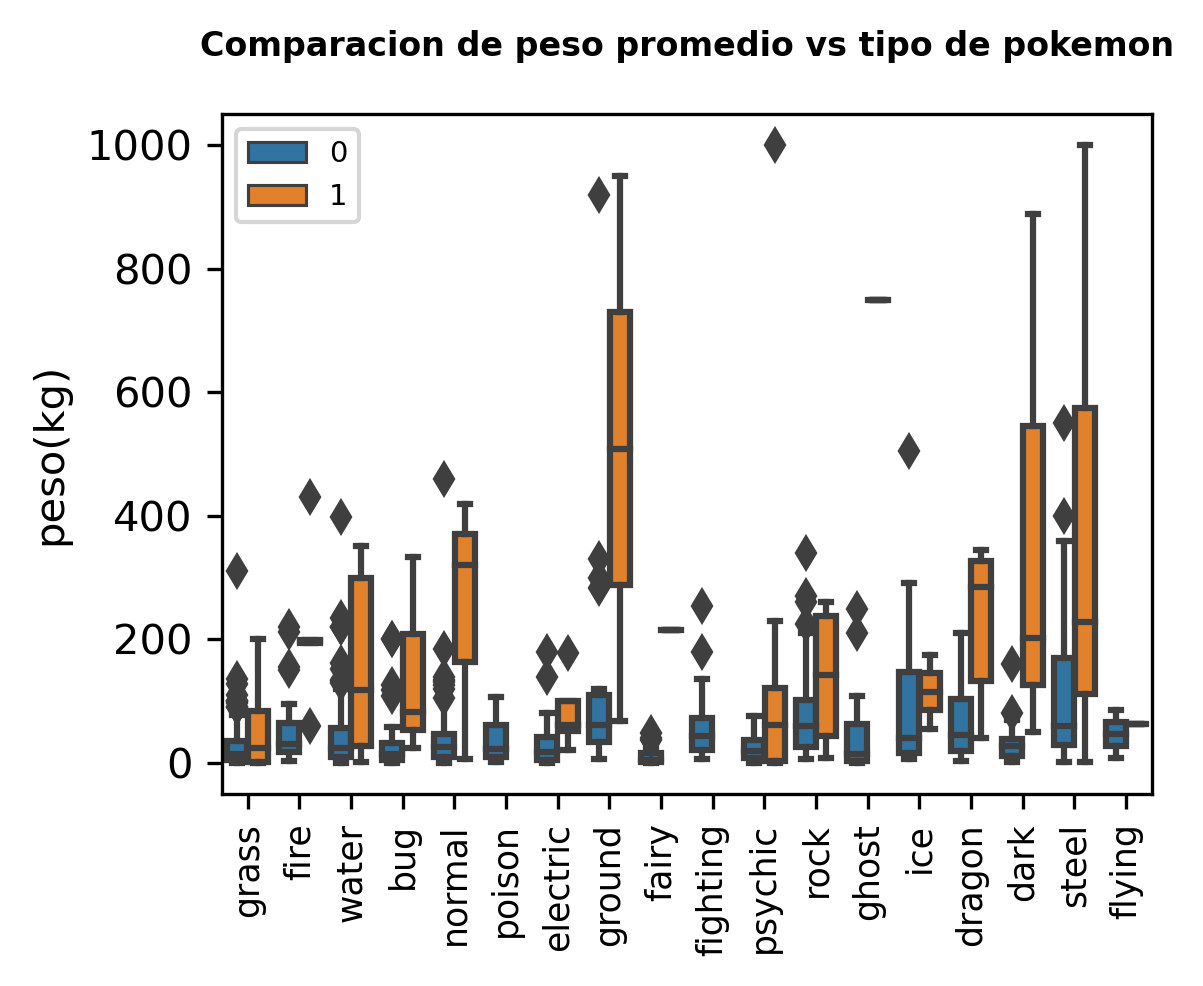

In [11]:
pdf = df.to_pandas()

plt.figure(figsize = (4,3), dpi = 300)

sns.boxplot(data = pdf, x = "clase", y = "peso(kg)", hue = "legendario")
plt.xticks(rotation = 90, fontsize = "small")
plt.legend(fontsize = "x-small")
plt.title("Comparacion de peso promedio vs tipo de pokemon", fontweight = "bold", fontsize = 8, pad = 14)
plt.xlabel("")
plt.show()

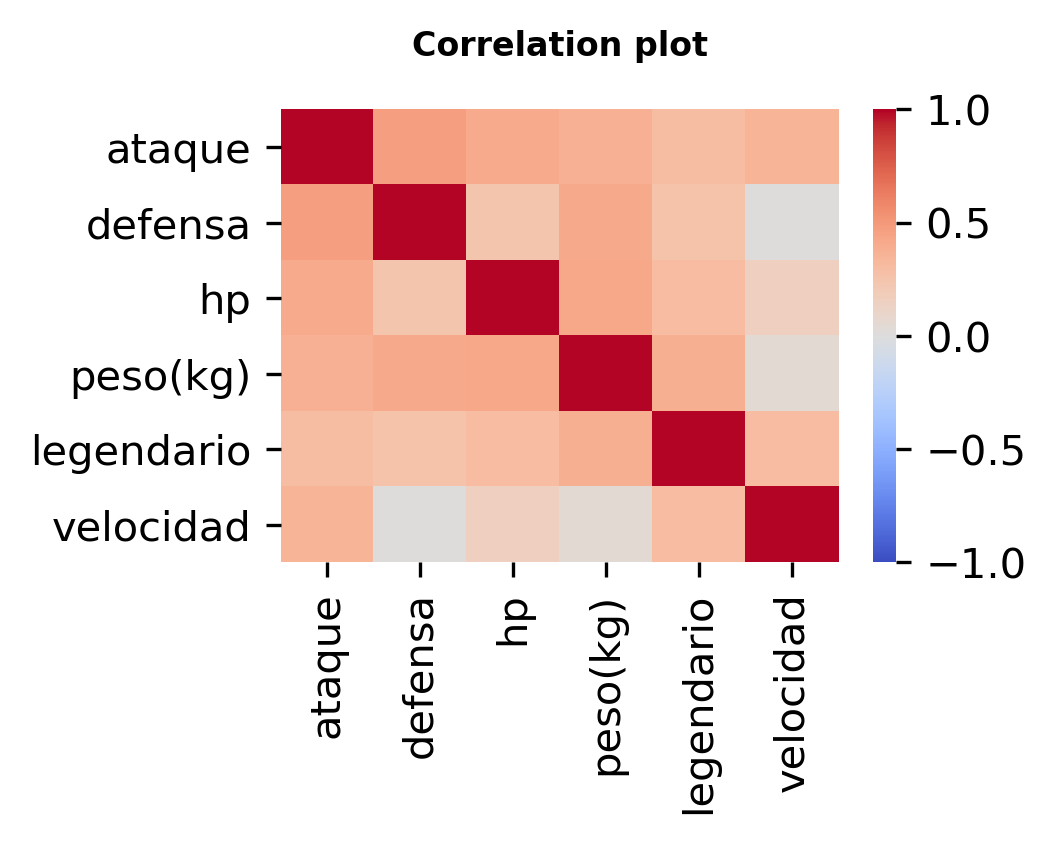

In [12]:
pdf = df.to_pandas()

corr = pdf.drop(columns = ["pokemon", "clase"]).corr()

plt.figure(figsize = (3,2), dpi = 300)

plt.title("Correlation plot", fontsize = 8, fontweight = "bold", pad = 13)

sns.heatmap(data = corr, vmin = -1, vmax = 1, cmap = "coolwarm")
plt.show()

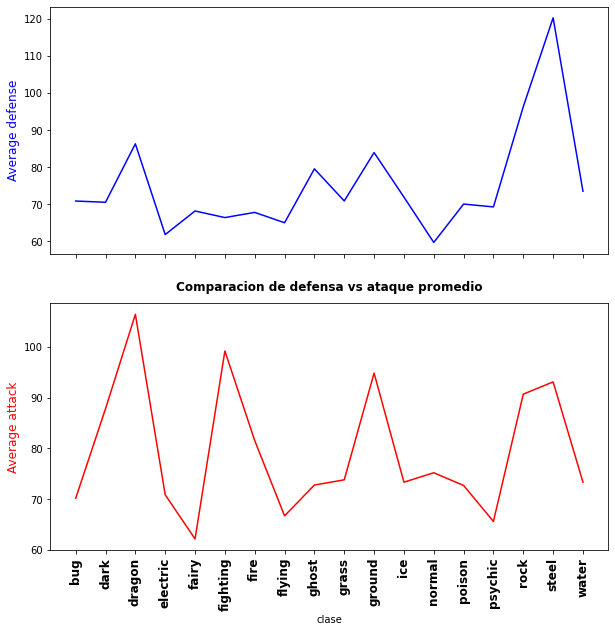

In [13]:
new = df.groupby("clase").mean().sort_values(by = "ataque", ascending = False)

clase = new.index.to_numpy()
def_medio = df.groupby("clase").mean().sort_values(by = "ataque", ascending = False)["defensa"].to_numpy()
at_media = df.groupby("clase").mean().sort_values(by = "ataque", ascending = False)["ataque"].to_numpy()

pdf = pd.DataFrame(data = dict(clase = clase, defensa = def_medio, ataque = at_media))

f, (ax1, ax2) = plt.subplots(sharex = True, nrows = 2, figsize = (10,10))

plt.title("Comparacion de defensa vs ataque promedio", fontsize = 12, fontweight = "bold", pad = 13)

sns.lineplot(data = pdf, x = "clase", y = "defensa", color = "blue", ax = ax1)
ax1.set_ylabel("Average defense", color = "blue", fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12, fontweight = "bold")
plt.xlabel("")

sns.lineplot(data = pdf, x = "clase", y = "ataque", color = "red", ax = ax2)
ax2.set_ylabel("Average attack", color = "red", fontsize = 12)
plt.show()

## PySpark ML

- Predicting whether a pokemon is legendary based on attack, defense, etc.

In [14]:
#import libraries

from pyspark.ml.feature import *
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

#### Bring data to PySpark

In [15]:
sdf = df.to_spark()

splits = sdf.randomSplit([0.8, 0.2], seed = 42)

train_df = splits[0].cache()

test_df = splits[1].cache()

train_df.count()
test_df.count()

129

In [16]:
sdf.show()

+------+-------+----------+------+---+-----------------+----------+---------+
|ataque|defensa|   pokemon| clase| hp|         peso(kg)|legendario|velocidad|
+------+-------+----------+------+---+-----------------+----------+---------+
|    49|     49| Bulbasaur| grass| 45|              6.9|         0|       45|
|    62|     63|   Ivysaur| grass| 60|             13.0|         0|       60|
|   100|    123|  Venusaur| grass| 80|            100.0|         0|       80|
|    52|     43|Charmander|  fire| 39|              8.5|         0|       65|
|    64|     58|Charmeleon|  fire| 58|             19.0|         0|       80|
|   104|     78| Charizard|  fire| 78|             90.5|         0|      100|
|    48|     65|  Squirtle| water| 44|              9.0|         0|       43|
|    63|     80| Wartortle| water| 59|             22.5|         0|       58|
|   103|    120| Blastoise| water| 79|             85.5|         0|       78|
|    30|     35|  Caterpie|   bug| 45|              2.9|        

### Random Forest

#### Build stages for pipeline

In [26]:
vectoriser_1 = VectorAssembler(inputCols = ["ataque", "defensa", "hp", "peso(kg)", "velocidad"], outputCol = "features", handleInvalid = "keep")

scaler = StandardScaler(inputCol = "features", outputCol = "scaled_features", withMean = True, withStd = True)

indexer = StringIndexer(inputCol = "clase", outputCol = "clase_indexed", handleInvalid = "keep")

vectoriser_2 = VectorAssembler(inputCols = ["scaled_features", "clase_indexed"], outputCol = "featuresCol", handleInvalid = "keep")

rf = RandomForestClassifier(featuresCol = "featuresCol", labelCol = "legendario", numTrees = 300, minInstancesPerNode = 1)

pipeline = Pipeline(stages = [vectoriser_1, scaler, indexer, vectoriser_2, rf])


#### Model fit and predictions

In [38]:
rf_model = pipeline.fit(train_df)

pred_df = rf_model.transform(test_df)

#### Evaluator

In [39]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "probability", labelCol = "legendario", metricName='areaUnderROC')

rf_auc = evaluator.evaluate(pred_df)

print(round(rf_auc, 2))

0.93


### RF: cross-validation

In [41]:
param_grid = ParamGridBuilder().addGrid(rf.numTrees, [100, 300, 500]).addGrid(rf.featureSubsetStrategy, ["sqrt", "log2"]).build()

cross_validator = CrossValidator(estimator = pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, seed=42)

model = cross_validator.fit(train_df)

In [ ]:
rf = model.bestModel.stages[4]  #best model from gridsearch cv

In [43]:
pred_df = model.transform(test_df)

rf_auc = evaluator.evaluate(pred_df)

print(round(rf_auc, 2))

0.94


In [44]:
model.bestModel.stages

[VectorAssembler_dfe55da03220,
 StandardScalerModel: uid=StandardScaler_96878111b528, numFeatures=5, withMean=true, withStd=true,
 StringIndexerModel: uid=StringIndexer_19d65bb39625, handleInvalid=keep,
 VectorAssembler_e64268a0d5b7,
 RandomForestClassificationModel: uid=RandomForestClassifier_8850eca1ba3c, numTrees=500, numClasses=2, numFeatures=6]

## Gradient Boosted Trees

In [17]:
from pyspark.ml.classification import GBTClassifier

#### Build model stages 

In [18]:
vectoriser_1 = VectorAssembler(inputCols = ['ataque', 'defensa', 'peso(kg)', 'velocidad'], outputCol = "features", handleInvalid = "keep")

scaler = StandardScaler(inputCol = "features", outputCol = "scaled_features", withMean = True, withStd = True)

indexer = StringIndexer(inputCol = "clase", outputCol = "clase_indexed", handleInvalid = "keep")

vectoriser_2 = VectorAssembler(inputCols = ["scaled_features", "clase_indexed"], outputCol = "featureCol")

gbt = GBTClassifier(featuresCol = "featureCol", labelCol = "legendario", maxIter = 100, stepSize = 0.1, seed = 42)

pipeline = Pipeline(stages = [vectoriser_1,scaler, indexer, vectoriser_2, gbt])


#### Fit model and get predictions

In [19]:
gbt_model = pipeline.fit(train_df)

pred_df = gbt_model.transform(test_df)


#### Evaluate on unseen data

In [20]:
evaluator = BinaryClassificationEvaluator(labelCol = "legendario", rawPredictionCol = "probability", metricName = 'areaUnderROC')

gbt_auc= evaluator.evaluate(pred_df)

print(round(gbt_auc, 2))

0.87


## GBT: cross-validation

In [ ]:
param_grid = ParamGridBuilder().addGrid(gbt.maxIter, [100,300,500]).addGrid(gbt.stepSize, [0.01, 0.1, 0.2, 0.3]).build()

cross_validator = CrossValidator(estimator = pipeline, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds = 3, seed = 42)

model = cross_validator.fit(train_df)

In [ ]:
gbt_best = model.bestModel.stages[4] 

In [ ]:
pred_df = model.transform(test_df)

gbt_auc= evaluator.evaluate(pred_df)

print(round(gbt_auc, 2))
